# Data Mining Assignment - 01

## Mehul Agarwal - 19020343027 - MBA BA - SCMHRD

Problem statement:
Build a classifier to assess status of loan defaults from the given data.
This assignment solution includes hands-on experience on:
1. Data Preprocessing
2. ML Model Building - evaluation & selection

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE 

%matplotlib inline

In [2]:
loan = pd.read_csv("Train_Data.csv")
loan.set_index("ID", inplace = True)
loan.reset_index(drop=True, inplace = True)
loan.head()

,Income_of_Applicant,Income_of_Joint_Applicant,Loan_Amount_Requirement,Loan_Amount_Term,Credit_History,Gender,Is_Married,No_of_Dependents,Level_of_Education,IS_Self_Employed,Area_of_Property,Loan_Status
0,5849,0.0,NaN,360.0,1.0,Male,No,0,Graduate,No,Urban,Y
1,4583,1508.0,128.0,360.0,1.0,Male,Yes,1,Graduate,No,Rural,N
2,3000,0.0,66.0,360.0,1.0,Male,Yes,0,Graduate,Yes,Urban,Y
3,2583,2358.0,120.0,360.0,1.0,Male,Yes,0,Not Graduate,No,Urban,Y
4,6000,0.0,141.0,360.0,1.0,Male,No,0,Graduate,No,Urban,Y


In [3]:
print("Total rows with missing values: " + str(round((loan.isnull().any(axis=1).sum()/loan.shape[0])*100,2)) + " % of total data!!!")

Total rows with missing values: 21.82 % of total data!!!


Text(0.5, 1.0, 'IS_Self_Employed')

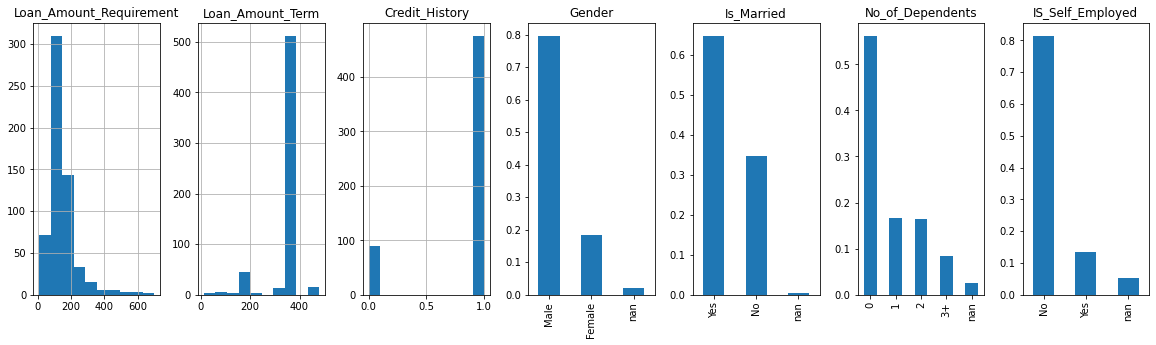

In [4]:
fig, axes = plt.subplots(1, 7, figsize = (20,5))

loan.hist("Loan_Amount_Requirement", ax = axes[0])
loan.hist("Loan_Amount_Term", ax = axes[1])
loan.hist("Credit_History", ax = axes[2])
loan.Gender.value_counts(normalize = True, dropna = False).plot(kind="bar", ax = axes[3]).set_title("Gender")
loan.Is_Married.value_counts(normalize = True, dropna = False).plot(kind="bar", ax = axes[4]).set_title("Is_Married")
loan.No_of_Dependents.value_counts(normalize = True, dropna = False).plot(kind="bar", ax = axes[5]).set_title("No_of_Dependents")
loan.IS_Self_Employed.value_counts(normalize = True, dropna = False).plot(kind="bar", ax = axes[6]).set_title("IS_Self_Employed")

Checking traget variable class!

In [5]:
(loan["Loan_Status"].value_counts(dropna=False)/len(loan["Loan_Status"]))*100

Y    68.729642
N    31.270358
Name: Loan_Status, dtype: float64

array([[<AxesSubplot:title={'center':'Income_of_Applicant'}>,
        <AxesSubplot:title={'center':'Income_of_Joint_Applicant'}>],
       [<AxesSubplot:title={'center':'Loan_Amount_Requirement'}>,
        <AxesSubplot:title={'center':'Loan_Amount_Term'}>],
       [<AxesSubplot:title={'center':'Credit_History'}>, <AxesSubplot:>]],
      dtype=object)

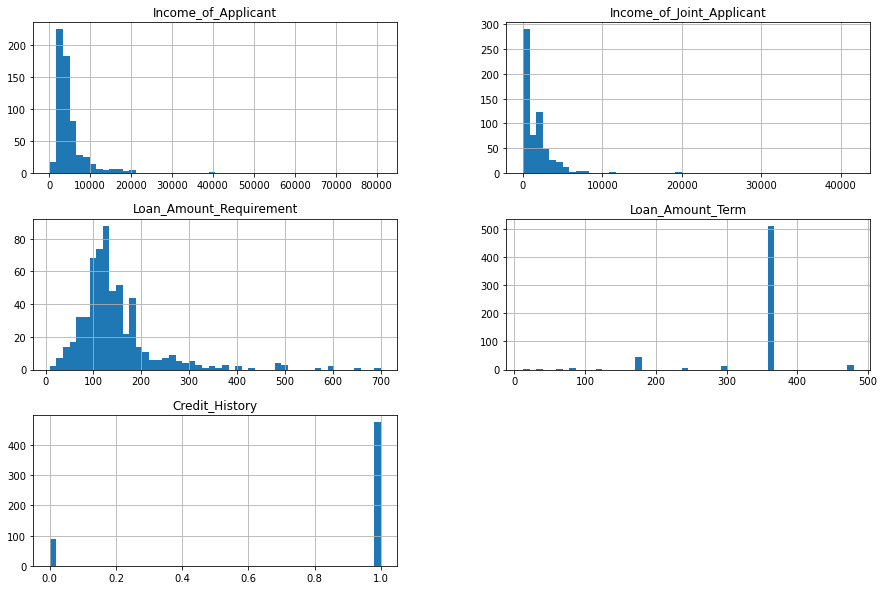

In [6]:
loan.hist(bins = 50, figsize = (15,10))

<AxesSubplot:>

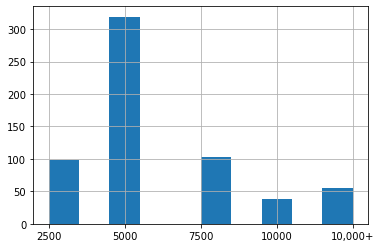

In [7]:
pd.cut(loan["Income_of_Applicant"], bins = [0., 2500., 5000., 7500., 10000., np.inf], labels = [2500, 5000, 7500, 10000, "10,000+"], right = False).sort_values().hist()

We see that income of applicants are distributed in a right skewed manner!

### Splitting data into training and test sets

In [8]:
# Changed
# This is stratified sampling based on "Loan Status".
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.3, random_state = 42)
for train_index_s, test_index_s in split.split(loan, loan["Loan_Status"]):
    strat_train_set = loan.iloc[train_index_s]
    strat_test_set = loan.iloc[test_index_s]

In [9]:
strat_train_set.head()

,Income_of_Applicant,Income_of_Joint_Applicant,Loan_Amount_Requirement,Loan_Amount_Term,Credit_History,Gender,Is_Married,No_of_Dependents,Level_of_Education,IS_Self_Employed,Area_of_Property,Loan_Status
197,1907,2365.0,120.0,NaN,1.0,Female,No,0,Not Graduate,No,Urban,Y
175,3497,1964.0,116.0,360.0,1.0,Male,Yes,0,Graduate,No,Rural,Y
526,3775,0.0,110.0,360.0,1.0,Male,Yes,0,Graduate,No,Semiurban,Y
149,4860,830.0,125.0,360.0,1.0,Male,Yes,0,Graduate,No,Semiurban,Y
507,3583,0.0,96.0,360.0,1.0,NaN,No,0,Graduate,No,Urban,N


### Splitting train set based on numerical & categorical features

In [10]:
# seperate the numerical & categorical features
train_num_col  = list(strat_train_set.select_dtypes(["int64","float"]).columns)
train_cat_col = list(strat_train_set.select_dtypes("object").columns)

In [11]:
print(train_num_col)
print(train_cat_col)

['Income_of_Applicant', 'Income_of_Joint_Applicant', 'Loan_Amount_Requirement', 'Loan_Amount_Term', 'Credit_History']
['Gender', 'Is_Married', 'No_of_Dependents', 'Level_of_Education', 'IS_Self_Employed', 'Area_of_Property', 'Loan_Status']


In [12]:
train_num = strat_train_set[train_num_col]
train_cat = strat_train_set[train_cat_col]

In [13]:
train_num.head(5)

,Income_of_Applicant,Income_of_Joint_Applicant,Loan_Amount_Requirement,Loan_Amount_Term,Credit_History
197,1907,2365.0,120.0,NaN,1.0
175,3497,1964.0,116.0,360.0,1.0
526,3775,0.0,110.0,360.0,1.0
149,4860,830.0,125.0,360.0,1.0
507,3583,0.0,96.0,360.0,1.0


### Imputing missing values based on "mean" for numerical features

In [14]:
imputer = SimpleImputer(strategy="mean")
imputer.fit(train_num)
print(imputer.statistics_)
train_num_imp = pd.DataFrame(imputer.transform(train_num), columns = train_num.columns, index = train_num.index)
train_num_imp.head(5)

[5.62321212e+03 1.58877622e+03 1.49239709e+02 3.40374101e+02
 8.58974359e-01]


,Income_of_Applicant,Income_of_Joint_Applicant,Loan_Amount_Requirement,Loan_Amount_Term,Credit_History
197,1907.0,2365.0,120.0,340.374101,1.0
175,3497.0,1964.0,116.0,360.000000,1.0
526,3775.0,0.0,110.0,360.000000,1.0
149,4860.0,830.0,125.0,360.000000,1.0
507,3583.0,0.0,96.0,360.000000,1.0


### Min-Max Scaling numerical features 

In [15]:
scaler = MinMaxScaler()
scaler.fit(train_num_imp)
train_num_tr = scaler.transform(train_num_imp)
train_num_tr = pd.DataFrame(scaler.transform(train_num_imp), columns = train_num.columns, index = train_num.index)
train_num_tr.head(5)

,Income_of_Applicant,Income_of_Joint_Applicant,Loan_Amount_Requirement,Loan_Amount_Term,Credit_History
197,0.021005,0.056760,0.160637,0.701654,1.0
175,0.040686,0.047136,0.154848,0.743590,1.0
526,0.044127,0.000000,0.146165,0.743590,1.0
149,0.057557,0.019920,0.167873,0.743590,1.0
507,0.041750,0.000000,0.125904,0.743590,1.0


### Label encoding & One-Hot encoding categorical features

In [16]:
to_binarize = ["Gender", "Is_Married", "Level_of_Education", "IS_Self_Employed", "Loan_Status"]
to_one_hot = ["No_of_Dependents", "Area_of_Property"]

### Imputing missing values based on "mode" for categorical features

In [17]:
# imputing missing values with "mode" values
train_cat = train_cat.apply(lambda x: x.fillna(x.value_counts().index[0]))
train_cat.head(5)

,Gender,Is_Married,No_of_Dependents,Level_of_Education,IS_Self_Employed,Area_of_Property,Loan_Status
197,Female,No,0,Not Graduate,No,Urban,Y
175,Male,Yes,0,Graduate,No,Rural,Y
526,Male,Yes,0,Graduate,No,Semiurban,Y
149,Male,Yes,0,Graduate,No,Semiurban,Y
507,Male,No,0,Graduate,No,Urban,N


In [18]:
# Label encoding & 1-hot encoding
def binarize_1hot(dataset, to_binarize, to_one_hot):
    for i in to_binarize:
        dataset[i] = LabelBinarizer().fit_transform(dataset[i])
    dataset = pd.get_dummies(data = dataset, columns = to_one_hot)
    return dataset

In [19]:
train_cat_tr = binarize_1hot(train_cat, to_binarize, to_one_hot)
train_cat_tr.head(5)

,Gender,Is_Married,Level_of_Education,IS_Self_Employed,Loan_Status,No_of_Dependents_0,No_of_Dependents_1,No_of_Dependents_2,No_of_Dependents_3+,Area_of_Property_Rural,Area_of_Property_Semiurban,Area_of_Property_Urban
197,0,0,1,0,1,1,0,0,0,0,0,1
175,1,1,0,0,1,1,0,0,0,1,0,0
526,1,1,0,0,1,1,0,0,0,0,1,0
149,1,1,0,0,1,1,0,0,0,0,1,0
507,1,0,0,0,0,1,0,0,0,0,0,1


In [20]:
train_tr = pd.concat([train_num_tr, train_cat_tr], axis=1)
train_tr.head(5)

,Income_of_Applicant,Income_of_Joint_Applicant,Loan_Amount_Requirement,Loan_Amount_Term,Credit_History,Gender,Is_Married,Level_of_Education,IS_Self_Employed,Loan_Status,No_of_Dependents_0,No_of_Dependents_1,No_of_Dependents_2,No_of_Dependents_3+,Area_of_Property_Rural,Area_of_Property_Semiurban,Area_of_Property_Urban
197,0.021005,0.056760,0.160637,0.701654,1.0,0,0,1,0,1,1,0,0,0,0,0,1
175,0.040686,0.047136,0.154848,0.743590,1.0,1,1,0,0,1,1,0,0,0,1,0,0
526,0.044127,0.000000,0.146165,0.743590,1.0,1,1,0,0,1,1,0,0,0,0,1,0
149,0.057557,0.019920,0.167873,0.743590,1.0,1,1,0,0,1,1,0,0,0,0,1,0
507,0.041750,0.000000,0.125904,0.743590,1.0,1,0,0,0,0,1,0,0,0,0,0,1


### Splitting predictors & target variables on train set

In [21]:
train_x = train_tr.drop("Loan_Status", axis = 1)
train_y = train_tr["Loan_Status"]

### Label encoding + 1-Hot encoding + missing value imputation + min max scaling for test set
### Splitting predictors & target variables on test set

In [22]:
test_num_col  = list(strat_test_set.select_dtypes(["int64","float"]).columns)
test_cat_col = list(strat_test_set.select_dtypes("object").columns)

test_num = strat_test_set[test_num_col]
test_cat = strat_test_set[test_cat_col]

imputer = SimpleImputer(strategy="median")
imputer.fit(test_num)

test_num_imp = pd.DataFrame(imputer.transform(test_num), columns = test_num.columns, index = test_num.index)
test_num_imp.head(10)

scaler = MinMaxScaler()
scaler.fit(test_num_imp)
test_num_tr = scaler.transform(test_num_imp)
test_num_tr = pd.DataFrame(scaler.transform(test_num_imp), columns = test_num.columns, index = test_num.index)

# imputing missing values with "mode" values
test_cat = test_cat.apply(lambda x: x.fillna(x.value_counts().index[0]))

test_cat_tr = binarize_1hot(test_cat, to_binarize, to_one_hot)

test_tr = pd.concat([test_num_tr, test_cat_tr], axis=1)

test_x = test_tr.drop("Loan_Status", axis = 1)
test_y = test_tr["Loan_Status"]

### Building Models

In [23]:
# testing multiple models
models = []
models.append(("LogisticRegression",LogisticRegression()))
models.append(("SVC",SVC()))
models.append(("LinearSVC",LinearSVC()))
models.append(("KNeighbors",KNeighborsClassifier()))
models.append(("DecisionTree",DecisionTreeClassifier()))
print(models)

[('LogisticRegression', LogisticRegression()), ('SVC', SVC()), ('LinearSVC', LinearSVC()), ('KNeighbors', KNeighborsClassifier()), ('DecisionTree', DecisionTreeClassifier())]


Classification report for : LogisticRegression
              precision    recall  f1-score   support

           0       0.94      0.55      0.70        58
           1       0.83      0.98      0.90       127

    accuracy                           0.85       185
   macro avg       0.88      0.77      0.80       185
weighted avg       0.86      0.85      0.84       185
 

Classification report for : SVC
              precision    recall  f1-score   support

           0       0.94      0.55      0.70        58
           1       0.83      0.98      0.90       127

    accuracy                           0.85       185
   macro avg       0.88      0.77      0.80       185
weighted avg       0.86      0.85      0.84       185
 

Classification report for : LinearSVC
              precision    recall  f1-score   support

           0       0.94      0.57      0.71        58
           1       0.83      0.98      0.90       127

    accuracy                           0.85       185
   macr

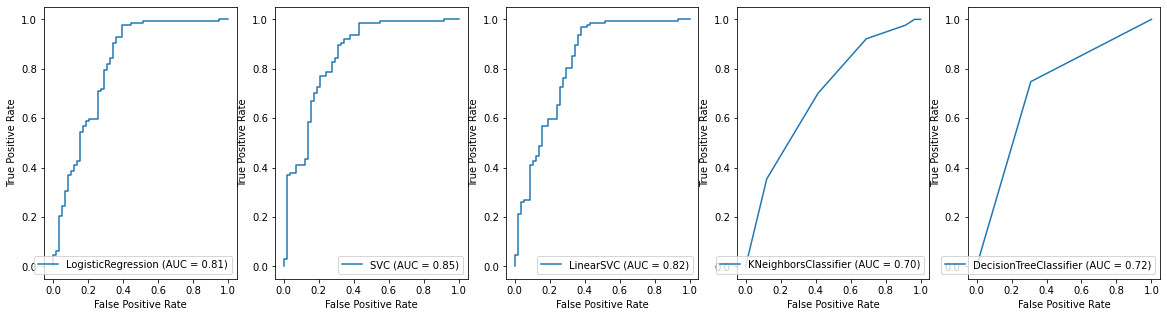

In [24]:
# check best performing model on test data!
fig, axes = plt.subplots(1, 5, figsize = (20,5))
i=0
for name, model in models:
    ml_model = model.fit(train_x,train_y)
    yhat = ml_model.predict(test_x)
    print("Classification report for :", name)
    print(classification_report(test_y, yhat), "\n")
    plot_roc_curve(ml_model, test_x, test_y, ax = axes[i])
    i+=1

We see that Logistic Regression model performs similar to SVC. Although, Linear SVC performs slightly better on the test data with an average F1-score of 0.805 for both classes.

### Checking performance after oversampling training data

In [25]:
print(train_x.shape)
train_y.value_counts()

(429, 16)


1    295
0    134
Name: Loan_Status, dtype: int64

#### Using SMOTE to oversample training data and artificially balance the traget variable classes

In [26]:
sm = SMOTE(random_state=42)
train_x, train_y = sm.fit_sample(train_x, train_y)

In [27]:
print(train_x.shape)
train_y.value_counts()

(590, 16)


1    295
0    295
Name: Loan_Status, dtype: int64

Classification report for : LogisticRegression
              precision    recall  f1-score   support

           0       0.66      0.72      0.69        58
           1       0.87      0.83      0.85       127

    accuracy                           0.79       185
   macro avg       0.76      0.78      0.77       185
weighted avg       0.80      0.79      0.80       185
 

Classification report for : SVC
              precision    recall  f1-score   support

           0       0.70      0.67      0.68        58
           1       0.85      0.87      0.86       127

    accuracy                           0.81       185
   macro avg       0.77      0.77      0.77       185
weighted avg       0.80      0.81      0.80       185
 

Classification report for : LinearSVC
              precision    recall  f1-score   support

           0       0.72      0.72      0.72        58
           1       0.87      0.87      0.87       127

    accuracy                           0.83       185
   macr

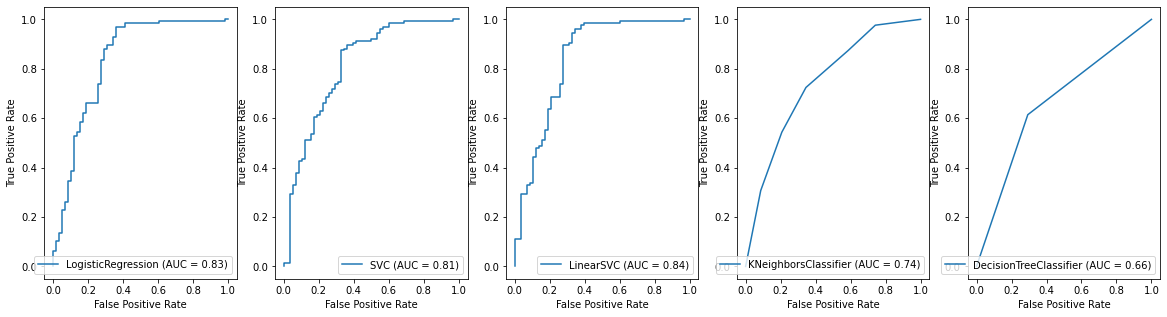

In [28]:
# check best performing model on test data!
fig, axes = plt.subplots(1, 5, figsize = (20,5))
i=0
for name, model in models:
    ml_model = model.fit(train_x,train_y)
    yhat = ml_model.predict(test_x)
    print("Classification report for :", name)
    print(classification_report(test_y, yhat), "\n")
    plot_roc_curve(ml_model, test_x, test_y, ax = axes[i])
    i+=1

Here we see that Linear SVC performs slightly better than others with an average F1-score of 0.795 for both classes.

#### F1-score vs Precision vs Recall
F1-score was chosen assuming that incorrect classifications of either class would have equal or similar (but opposite) implications.

### Conclusion

Based on the results above, we see that oversampling the training set increases F1-score only in case of KNN based model while the F1-score drops in all other cases.
#### The best performing model in both cases was the LinearSVC which acheived average F1-score of 0.805 without oversampling of the training data.